In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
from pyspark.sql.functions import *
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")

# Preparing Data

## Create SparkSession

In [7]:
# spark = SparkSession.builder.appName("NYC_ETA").config("spark.some.config.option", "some-value").getOrCreate()

In [206]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .appName("NYC_ETA") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.python.executable", sys.executable) \
    .config("spark.sql.shuffle.partitions", "10") \
    .getOrCreate()


## Read Parquet Files

In [211]:
# Merge all data parquet files

jul_data_path = "../data/yellow_tripdata_2024-07.parquet"
aug_data_path = "../data/yellow_tripdata_2024-08.parquet"
sep_data_path = "../data/yellow_tripdata_2024-09.parquet"
df_jul = spark.read.parquet(jul_data_path)
df_aug = spark.read.parquet(aug_data_path)
df_sep = spark.read.parquet(sep_data_path)

df = df_jul.union(df_aug).union(df_sep)

output_path = "../data/merged_yellow_tripdata_2024_Q3.parquet"
# df.write.parquet(output_path)

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|                 N|         140|          79|           1|       15.6|  3.5|    0.5|       3.

In [4]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



![data_schema.png](./data_schema.png)

### Merge Taxi Zone Data

In [4]:
zones_df = spark.read.csv("../data/taxi_zone_lookup.csv", header=True, inferSchema=True)
zones_df.show()

+-------+-------------+--------------------+--------------------+
|zone_id|      borough|           zone_name|           zone_geom|
+-------+-------------+--------------------+--------------------+
|      1|          EWR|      Newark Airport|POLYGON((-74.1856...|
|      2|       Queens|         Jamaica Bay|MULTIPOLYGON(((-7...|
|      3|        Bronx|Allerton/Pelham G...|POLYGON((-73.8485...|
|      4|    Manhattan|       Alphabet City|POLYGON((-73.9717...|
|      5|Staten Island|       Arden Heights|POLYGON((-74.1748...|
|      6|Staten Island|Arrochar/Fort Wad...|POLYGON((-74.0642...|
|      7|       Queens|             Astoria|POLYGON((-73.9041...|
|      8|       Queens|        Astoria Park|POLYGON((-73.9232...|
|      9|       Queens|          Auburndale|POLYGON((-73.7851...|
|     10|       Queens|        Baisley Park|POLYGON((-73.7840...|
|     11|     Brooklyn|          Bath Beach|POLYGON((-74.0018...|
|     12|    Manhattan|        Battery Park|POLYGON((-74.0156...|
|     13| 

#### Merge **zones_df** with **df** by **Pick Up Location**

In [212]:
df = df.join(zones_df, df.PULocationID == zones_df.zone_id, "inner")

df = df \
    .withColumnRenamed("borough", "pu_borough") \
    .withColumnRenamed("zone_name", "pu_zone") \
    .withColumnRenamed("PULocationID", "pu_zone_id")

df = df.drop("zone_geom","zone_id")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|pu_zone_id|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pu_borough|             pu_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|   

#### Merge **zones_df** with **df** by **Drop Off Location**

In [213]:
df = df.join(zones_df, df.DOLocationID == zones_df.zone_id, "inner")

df = df \
    .withColumnRenamed("borough", "do_borough") \
    .withColumnRenamed("zone_name", "do_zone") \
    .withColumnRenamed("DOLocationID", "do_zone_id")

df = df.drop("zone_geom","zone_id")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+----------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|pu_zone_id|do_zone_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pu_borough|             pu_zone|do_borough|             do_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+----------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|      

#### Drop some irrelevant columns which has no or little impact in estimate time arrival

In [214]:
columns_to_drop = [
    'VendorID',
    'RatecodeID',
    "store_and_fwd_flag", 
    "payment_type", 
    "fare_amount", 
    "extra", 
    "mta_tax", 
    "tip_amount", 
    "tolls_amount", 
    "improvement_surcharge", 
    "total_amount"
]

df = df.drop(*columns_to_drop)

df.show(5)


+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+-----------+----------+--------------------+----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pu_zone_id|do_zone_id|congestion_surcharge|Airport_fee|pu_borough|             pu_zone|do_borough|             do_zone|
+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+-----------+----------+--------------------+----------+--------------------+
| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|       140|        79|                 2.5|        0.0| Manhattan|     Lenox Hill East| Manhattan|        East Village|
| 2024-06-30 23:48:58|  2024-07-01 00:28:04|              1|        19.48|       132|       113|                 2.5|       1.75|    Queens|         JFK Airport| Manhattan|Greenwich Village...|
| 2024-07-01 00:23:18|  2024-0

# Preprocessing Data

## Data Cleaning

#### trip_distance


In [215]:
from pyspark.sql.functions import col, mean as spark_mean, stddev

# Calculate mean and standard deviation
trip_dis_stats = df.select(
    spark_mean(col("trip_distance")).alias("mean"),
    stddev(col("trip_distance")).alias("stddev")
).collect()[0]
trip_dis_stats

Row(mean=5.194878593083578, stddev=433.0885744571877)

In [216]:
trip_dis_mean = trip_dis_stats["mean"]
trip_dis_stddev = trip_dis_stats["stddev"]

print(f"Mean for Trip Duration is: {trip_dis_mean}")
print(f"Standard Deviation for Trip Duration is: {trip_dis_stddev}")

# Filter rows within 2 standard deviations
df = df.filter(
    (col("trip_distance") >= trip_dis_mean - 2 * trip_dis_stddev) &
    (col("trip_distance") <= trip_dis_mean + 2 * trip_dis_stddev) &
    (col("trip_distance") >= 1)
)

df.describe().show()

Mean for Trip Duration is: 5.194878593083578
Standard Deviation for Trip Duration is: 433.0885744571877
+-------+------------------+------------------+------------------+-----------------+--------------------+------------------+-------------+--------------------+-------------+--------------------+
|summary|   passenger_count|     trip_distance|        pu_zone_id|       do_zone_id|congestion_surcharge|       Airport_fee|   pu_borough|             pu_zone|   do_borough|             do_zone|
+-------+------------------+------------------+------------------+-----------------+--------------------+------------------+-------------+--------------------+-------------+--------------------+
|  count|           6526047|           7382701|           7382701|          7382701|             6526047|           6526047|      7382701|             7382701|      7382701|             7382701|
|   mean|1.3471721855512226|4.3031267567251525|160.37721682078146|158.8239747214468|  2.2094546668143824|0.207161778

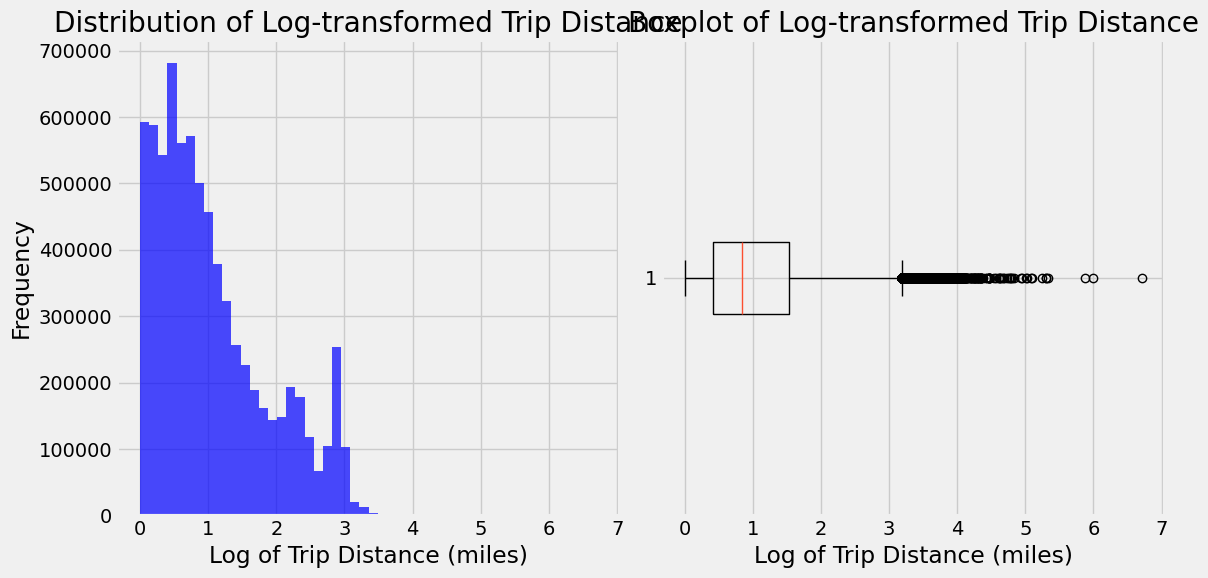

In [156]:
trip_distance_data = df.select("trip_distance").toPandas()

trip_distance_data = trip_distance_data[trip_distance_data['trip_distance'] > 0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.log(trip_distance_data['trip_distance']), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Log-transformed Trip Distance')
plt.xlabel('Log of Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(np.log(trip_distance_data['trip_distance']), vert=False)
plt.title('Boxplot of Log-transformed Trip Distance')
plt.xlabel('Log of Trip Distance (miles)')
plt.grid(True)

plt.tight_layout()
plt.show()


#### passenger_count

Filter rows where `passenger_count` is 7, 8, 9 or 0 because it is uncommon in NYC taxi data
> *(most taxis accommodate up to 6 passengers)*

In [157]:
from pyspark.sql.functions import col
df = df.filter(~(col("passenger_count").isin([7, 8, 9, 0])))

##### airport_fee to enter_airport

In [158]:
from pyspark.sql.functions import when

df = df.withColumn(
    "enter_airport", 
    when(col("airport_fee") > 0, 1).otherwise(0)
)
df.select("enter_airport").show(5)


+-------------+
|enter_airport|
+-------------+
|            0|
|            1|
|            0|
|            1|
|            0|
+-------------+
only showing top 5 rows



In [159]:
df = df.drop("airport_fee")

##### pick_up and drop_off datetime

In [160]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss")) \
       .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))

df.select("tpep_pickup_datetime", "tpep_dropoff_datetime").show(truncate=False)


+--------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|
+--------------------+---------------------+
|2024-07-01 07:34:56 |2024-07-01 07:46:49  |
|2024-07-01 06:48:58 |2024-07-01 07:28:04  |
|2024-07-01 07:23:18 |2024-07-01 07:29:51  |
|2024-07-01 07:07:55 |2024-07-01 07:34:34  |
|2024-07-01 07:19:42 |2024-07-01 07:32:13  |
|2024-07-01 07:34:04 |2024-07-01 07:43:13  |
|2024-07-01 07:59:52 |2024-07-01 08:05:27  |
|2024-07-01 07:13:50 |2024-07-01 07:28:03  |
|2024-07-01 07:43:34 |2024-07-01 08:01:43  |
|2024-07-01 07:52:25 |2024-07-01 08:17:53  |
|2024-07-01 07:51:18 |2024-07-01 08:01:42  |
|2024-07-01 07:33:24 |2024-07-01 07:54:44  |
|2024-07-01 07:56:52 |2024-07-01 08:12:59  |
|2024-07-01 07:36:26 |2024-07-01 07:50:42  |
|2024-07-01 07:59:32 |2024-07-01 08:07:58  |
|2024-07-01 07:16:06 |2024-07-01 07:45:42  |
|2024-07-01 07:56:04 |2024-07-01 08:13:10  |
|2024-07-01 07:18:04 |2024-07-01 07:49:00  |
|2024-07-01 07:09:49 |2024-07-01 07:36:44  |
|2024-07-0

`tpep_pickup_datetime`

In [161]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

df = df.withColumn("pickup_date", F.to_date(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_minute", F.minute(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_second", F.second(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_weekday", F.dayofweek(F.col("tpep_pickup_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("pickup_month", F.month(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_day", F.day(F.col("tpep_pickup_datetime")))


# Weekly hour feature (captures patterns based on the time of day and the day of the week)
df = df.withColumn(
    "pickup_week_hour", F.col("pickup_weekday") * 24 + F.col("pickup_hour")  # 0 (Sunday midnight) to 167 (Saturday 11:00 PM)
)

# df = df.withColumn(
#     "pickup_time", 
#     F.concat(
#         F.lpad(F.col("pickup_hour"), 2, "0"), F.lit(":"),
#         F.lpad(F.col("pickup_minute"), 2, "0"), F.lit(":"),
#         F.lpad(F.col("pickup_second"), 2, "0")
#     )
# )

In [162]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|pu_zone_id|do_zone_id|congestion_surcharge|pu_borough|             pu_zone|do_borough|             do_zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|
+--------+--------------------+---------------------+---------------+-------------+----------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+
|       1| 2024-07-01 07:34:

`tpep_dropoff_datetime`

In [163]:
df = df.withColumn("dropoff_date", F.to_date(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_hour", F.hour(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_minute", F.minute(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_second", F.second(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_weekday", F.dayofweek(F.col("tpep_dropoff_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("dropoff_month", F.month(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_day", F.day(F.col("tpep_dropoff_datetime")))

# df = df.withColumn(
#     "dropoff_time", 
#     F.concat(
#         F.lpad(F.col("dropoff_hour"), 2, "0"), F.lit(":"),
#         F.lpad(F.col("dropoff_minute"), 2, "0"), F.lit(":"),
#         F.lpad(F.col("dropoff_second"), 2, "0")
#     )
# )

df.select(
    "pickup_date", "pickup_month", "pickup_day", "pickup_weekday", "pickup_hour", "pickup_minute", "pickup_second", 
    "pickup_week_hour", "dropoff_date", "dropoff_month", "dropoff_day", "dropoff_hour", "dropoff_minute", "dropoff_second"
).show(truncate=False)


+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+-------------+-----------+------------+--------------+--------------+
|pickup_date|pickup_month|pickup_day|pickup_weekday|pickup_hour|pickup_minute|pickup_second|pickup_week_hour|dropoff_date|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_second|
+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+-------------+-----------+------------+--------------+--------------+
|2024-07-01 |7           |1         |1             |7          |34           |56           |31              |2024-07-01  |7            |1          |7           |46            |49            |
|2024-07-01 |7           |1         |1             |6          |48           |58           |30              |2024-07-01  |7            |1          |7           |28            |4             |
|2024-07-01 |7           |1         |1  

In [164]:
df = df.withColumn(
    "trip_duration_seconds", 
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) 
)
df = df.filter(col("trip_duration_seconds") <= 72000)

df.select("trip_duration_seconds").show(5)


+---------------------+
|trip_duration_seconds|
+---------------------+
|                  713|
|                 2346|
|                  393|
|                 1599|
|                  751|
+---------------------+
only showing top 5 rows



In [165]:
df = df.withColumn("trip_duration_minutes",col("trip_duration_seconds")/60)
df.select("trip_duration_seconds","trip_duration_minutes").show(5)

+---------------------+---------------------+
|trip_duration_seconds|trip_duration_minutes|
+---------------------+---------------------+
|                  713|   11.883333333333333|
|                 2346|                 39.1|
|                  393|                 6.55|
|                 1599|                26.65|
|                  751|   12.516666666666667|
+---------------------+---------------------+
only showing top 5 rows



In [166]:
df = df.drop("trip_duration_seconds")

#### speed in miles per hour

In [167]:
df = df.withColumn("speed_mph", F.col("trip_distance") / (F.col("trip_duration_minutes") / 60))
min_speed = 0
max_speed = 100

df = df.filter((F.col("speed_mph") >= min_speed) & (F.col("speed_mph") <= max_speed))
df.select("speed_mph").describe().show(5)

+-------+--------------------+
|summary|           speed_mph|
+-------+--------------------+
|  count|             6461512|
|   mean|  11.992574301814653|
| stddev|   6.763916143498728|
|    min|0.056768743400211194|
|    max|               100.0|
+-------+--------------------+



#### Remove rows with IQR of speed

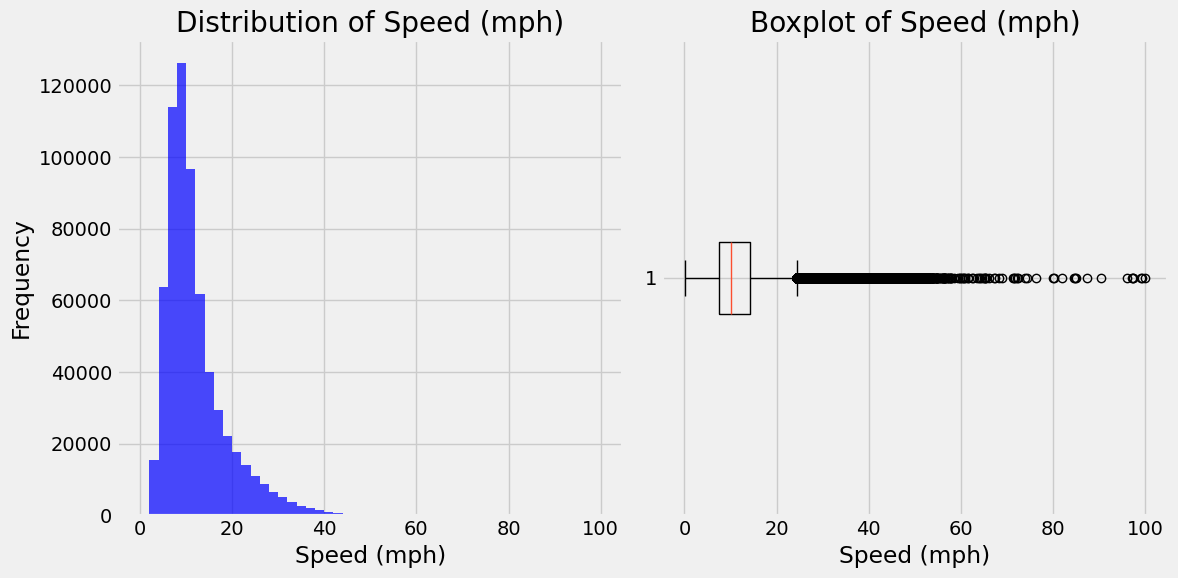

In [168]:
# Convert the speed_mph column to a pandas DataFrame for visualization
speed_data = df.select("speed_mph").sample(fraction=0.1, seed=42).toPandas()

# Plot the distribution of speed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(speed_data['speed_mph'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the boxplot of speed
plt.subplot(1, 2, 2)
plt.boxplot(speed_data['speed_mph'], vert=False)
plt.title('Boxplot of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [169]:
# Calculate the IQR for speed_mph
Q1_speed = df.approxQuantile("speed_mph", [0.25], 0.05)[0]
Q3_speed = df.approxQuantile("speed_mph", [0.75], 0.05)[0]
IQR_speed = Q3_speed - Q1_speed

# Define the lower and upper bounds for outliers
lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

# Filter the dataframe to remove outliers
df = df.filter((col("speed_mph") >= lower_bound_speed) & (col("speed_mph") <= upper_bound_speed))

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+------------+------------+--------------+--------------+---------------+-------------+-----------+---------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|pu_zone_id|do_zone_id|congestion_surcharge|pu_borough|             pu_zone|do_borough|             do_zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|trip_duration_minutes|         speed_mph|
+--------+--------------------+---------------------+---------------+-----

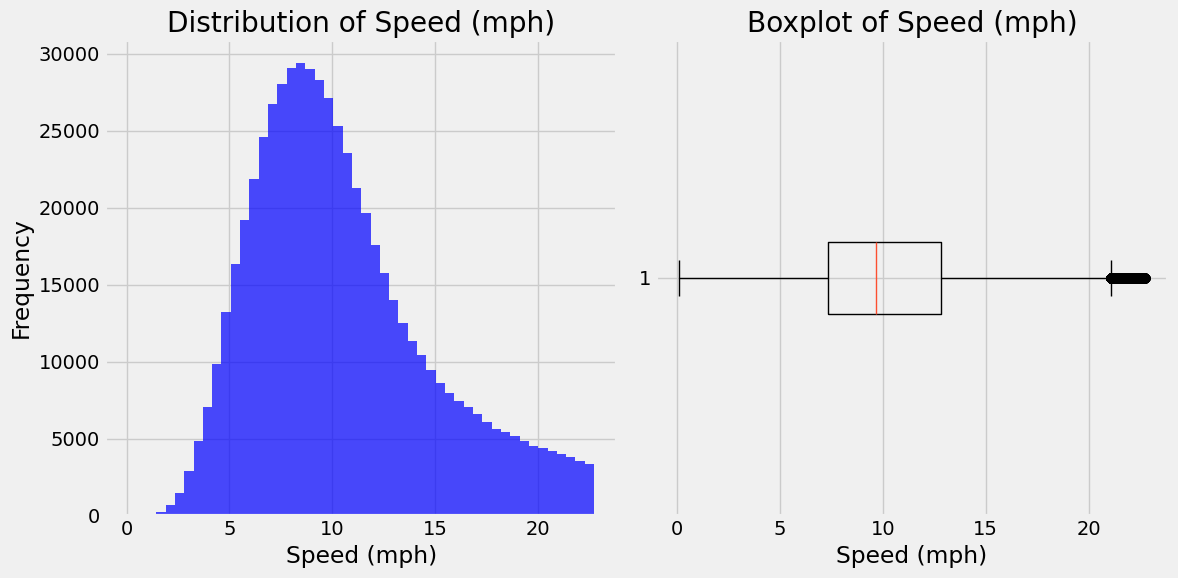

In [170]:
# Convert the speed_mph column to a pandas DataFrame for visualization
speed_data = df.select("speed_mph").sample(fraction=0.1, seed=42).toPandas()

# Plot the distribution of speed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(speed_data['speed_mph'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the boxplot of speed
plt.subplot(1, 2, 2)
plt.boxplot(speed_data['speed_mph'], vert=False)
plt.title('Boxplot of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [171]:
df = df.drop("speed_mph")

#### Visualize the Total trip duration throughout a day every day in July

In [109]:
july_data = df.filter(F.col("pickup_month") == 7)

july_data = july_data.groupBy("pickup_day").agg(
    F.sum("trip_duration_seconds").alias("total_trip_duration_seconds"),
    F.count("pickup_day").alias("trip_count")
)

july_data = july_data.orderBy("pickup_day")

pandas_july_data = july_data.toPandas()

plt.figure(figsize=(10, 5))

plt.plot(pandas_july_data['pickup_day'], pandas_july_data['total_trip_duration_seconds'], linestyle='-', marker='o', color='b', alpha=0.6)

plt.title('Total Trip Duration in July by Day of the Month', fontsize=12)
plt.xlabel('Day of the Month', fontsize=8)
plt.ylabel('Total Trip Duration (Seconds)', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `trip_duration_seconds` cannot be resolved. Did you mean one of the following? [`trip_duration_minutes`, `dropoff_second`, `pickup_second`, `trip_distance`, `pu_zone_id`].;
'Aggregate [pickup_day#10260], [pickup_day#10260, sum('trip_duration_seconds) AS total_trip_duration_seconds#11157]
+- Filter (pickup_month#10239 = 7)
   +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 6 more fields]
      +- Filter ((speed_mph#10678 >= -1.756520399121623) AND (speed_mph#10678 <= 22.725199368185844))
         +- Filter ((speed_mph#10678 >= cast(0 as double)) AND (speed_mph#10678 <= cast(100 as double)))
            +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 7 more fields]
               +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 6 more fields]
                  +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 7 more fields]
                     +- Filter (trip_duration_seconds#10566L <= cast(72000 as bigint))
                        +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 6 more fields]
                           +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 5 more fields]
                              +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 4 more fields]
                                 +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 3 more fields]
                                    +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, ... 2 more fields]
                                       +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, dropoff_hour#10329, minute(tpep_dropoff_datetime#10122, Some(Asia/Saigon)) AS dropoff_minute#10354]
                                          +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, dropoff_date#10305, hour(tpep_dropoff_datetime#10122, Some(Asia/Saigon)) AS dropoff_hour#10329]
                                             +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, pickup_week_hour#10282, to_date(tpep_dropoff_datetime#10122, None, Some(Asia/Saigon), false) AS dropoff_date#10305]
                                                +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, pickup_day#10260, ((pickup_weekday#10219 * 24) + pickup_hour#10165) AS pickup_week_hour#10282]
                                                   +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, pickup_month#10239, day(cast(tpep_pickup_datetime#10107 as date)) AS pickup_day#10260]
                                                      +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, pickup_weekday#10219, month(cast(tpep_pickup_datetime#10107 as date)) AS pickup_month#10239]
                                                         +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, pickup_second#10200, (dayofweek(cast(tpep_pickup_datetime#10107 as date)) - 1) AS pickup_weekday#10219]
                                                            +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, pickup_minute#10182, second(tpep_pickup_datetime#10107, Some(Asia/Saigon)) AS pickup_second#10200]
                                                               +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, pickup_hour#10165, minute(tpep_pickup_datetime#10107, Some(Asia/Saigon)) AS pickup_minute#10182]
                                                                  +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, pickup_date#10149, hour(tpep_pickup_datetime#10107, Some(Asia/Saigon)) AS pickup_hour#10165]
                                                                     +- Project [VendorID#7805, tpep_pickup_datetime#10107, tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070, to_date(tpep_pickup_datetime#10107, None, Some(Asia/Saigon), false) AS pickup_date#10149]
                                                                        +- Project [VendorID#7805, tpep_pickup_datetime#10107, to_timestamp(tpep_dropoff_datetime#7807, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Saigon), false) AS tpep_dropoff_datetime#10122, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070]
                                                                           +- Project [VendorID#7805, to_timestamp(tpep_pickup_datetime#7806, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Saigon), false) AS tpep_pickup_datetime#10107, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070]
                                                                              +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, enter_airport#10070]
                                                                                 +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380, CASE WHEN (airport_fee#7823 > cast(0 as double)) THEN 1 ELSE 0 END AS enter_airport#10070]
                                                                                    +- Filter NOT cast(passenger_count#7808L as bigint) IN (cast(7 as bigint),cast(8 as bigint),cast(9 as bigint),cast(0 as bigint))
                                                                                       +- Filter (((trip_distance#7809 >= -860.9822703212918) AND (trip_distance#7809 <= 871.3720275074589)) AND (trip_distance#7809 >= cast(1 as double)))
                                                                                          +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, pu_zone_id#8166, do_zone_id#8406, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380]
                                                                                             +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, pu_zone_id#8166, do_zone_id#8406, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142, do_borough#8354, do_zone#8380]
                                                                                                +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, pu_zone_id#8166, DOLocationID#7813 AS do_zone_id#8406, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142, zone_id#8299, do_borough#8354, do_zone#8380, zone_geom#8302]
                                                                                                   +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, pu_zone_id#8166, DOLocationID#7813, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142, zone_id#8299, do_borough#8354, zone_name#8301 AS do_zone#8380, zone_geom#8302]
                                                                                                      +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, pu_zone_id#8166, DOLocationID#7813, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142, zone_id#8299, borough#8300 AS do_borough#8354, zone_name#8301, zone_geom#8302]
                                                                                                         +- Join Inner, (DOLocationID#7813 = zone_id#8299)
                                                                                                            :- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, pu_zone_id#8166, DOLocationID#7813, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, pu_borough#8118, pu_zone#8142]
                                                                                                            :  +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, PULocationID#7812 AS pu_zone_id#8166, DOLocationID#7813, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, zone_id#284, pu_borough#8118, pu_zone#8142, zone_geom#287]
                                                                                                            :     +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, PULocationID#7812, DOLocationID#7813, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, zone_id#284, pu_borough#8118, zone_name#286 AS pu_zone#8142, zone_geom#287]
                                                                                                            :        +- Project [VendorID#7805, tpep_pickup_datetime#7806, tpep_dropoff_datetime#7807, passenger_count#7808L, trip_distance#7809, RatecodeID#7810L, store_and_fwd_flag#7811, PULocationID#7812, DOLocationID#7813, payment_type#7814L, fare_amount#7815, extra#7816, mta_tax#7817, tip_amount#7818, tolls_amount#7819, improvement_surcharge#7820, total_amount#7821, congestion_surcharge#7822, Airport_fee#7823, zone_id#284, borough#285 AS pu_borough#8118, zone_name#286, zone_geom#287]
                                                                                                            :           +- Join Inner, (PULocationID#7812 = zone_id#284)
                                                                                                            :              :- Union false, false
                                                                                                            :              :  :- Relation [VendorID#7805,tpep_pickup_datetime#7806,tpep_dropoff_datetime#7807,passenger_count#7808L,trip_distance#7809,RatecodeID#7810L,store_and_fwd_flag#7811,PULocationID#7812,DOLocationID#7813,payment_type#7814L,fare_amount#7815,extra#7816,mta_tax#7817,tip_amount#7818,tolls_amount#7819,improvement_surcharge#7820,total_amount#7821,congestion_surcharge#7822,Airport_fee#7823] parquet
                                                                                                            :              :  :- Relation [VendorID#7843,tpep_pickup_datetime#7844,tpep_dropoff_datetime#7845,passenger_count#7846L,trip_distance#7847,RatecodeID#7848L,store_and_fwd_flag#7849,PULocationID#7850,DOLocationID#7851,payment_type#7852L,fare_amount#7853,extra#7854,mta_tax#7855,tip_amount#7856,tolls_amount#7857,improvement_surcharge#7858,total_amount#7859,congestion_surcharge#7860,Airport_fee#7861] parquet
                                                                                                            :              :  +- Relation [VendorID#7881,tpep_pickup_datetime#7882,tpep_dropoff_datetime#7883,passenger_count#7884L,trip_distance#7885,RatecodeID#7886L,store_and_fwd_flag#7887,PULocationID#7888,DOLocationID#7889,payment_type#7890L,fare_amount#7891,extra#7892,mta_tax#7893,tip_amount#7894,tolls_amount#7895,improvement_surcharge#7896,total_amount#7897,congestion_surcharge#7898,Airport_fee#7899] parquet
                                                                                                            :              +- Relation [zone_id#284,borough#285,zone_name#286,zone_geom#287] csv
                                                                                                            +- Relation [zone_id#8299,borough#8300,zone_name#8301,zone_geom#8302] csv


##### Total number of trips every weekday

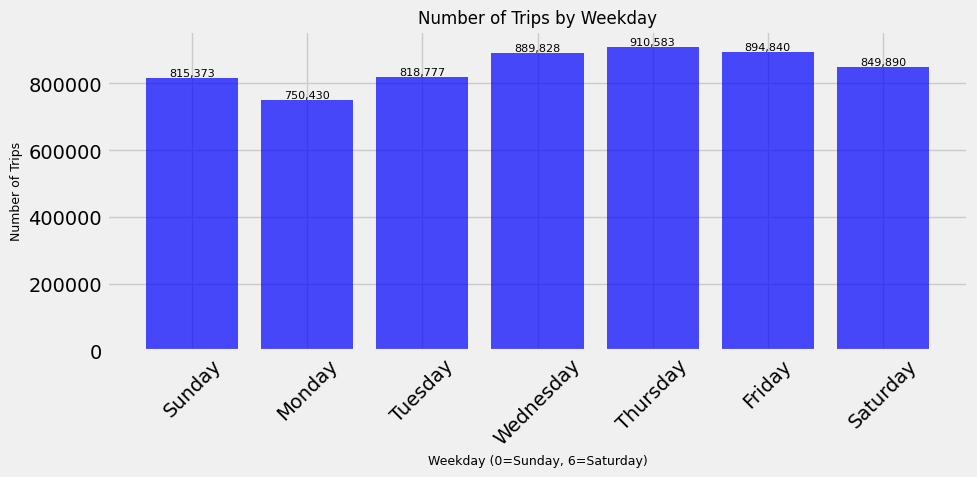

In [172]:
# Group by pickup_weekday and count the number of trips
weekday_trip_count = df.groupBy("pickup_weekday").agg(F.count("pickup_weekday").alias("trip_count"))

# Order by pickup_weekday
weekday_trip_count = weekday_trip_count.orderBy("pickup_weekday")

# Convert to Pandas DataFrame for plotting
pandas_weekday_trip_count = weekday_trip_count.toPandas()

# Create the plot
plt.figure(figsize=(10, 5))

# Create bars
bars = plt.bar(pandas_weekday_trip_count['pickup_weekday'], 
               pandas_weekday_trip_count['trip_count'], 
               color='b', 
               alpha=0.7)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{int(height):,}',  # Format number with comma separators
             ha='center',         # Horizontal alignment
             va='bottom',        # Vertical alignment
             fontsize=8)         # Font size

# Customize the plot
plt.title('Number of Trips by Weekday', fontsize=12)
plt.xlabel('Weekday (0=Sunday, 6=Saturday)', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

# Add weekday names on x-axis (optional)
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.xticks(range(7), weekday_names, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

#### Visualize the number of trips occur in each hour throughout a day

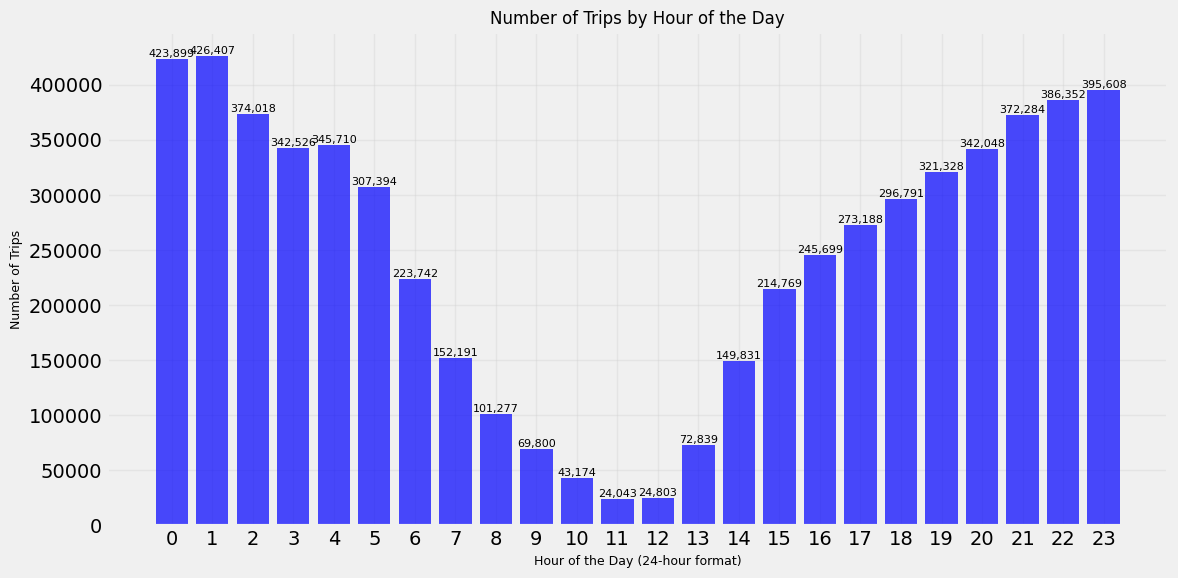

In [111]:
hourly_trip_count = df.groupBy("pickup_hour").agg(
    F.count("pickup_hour").alias("trip_count")
)

hourly_trip_count = hourly_trip_count.orderBy("pickup_hour")

pandas_hourly_trip_count = hourly_trip_count.toPandas()

plt.figure(figsize=(12, 6))  # Increased figure size for better readability

# Create bars
bars = plt.bar(pandas_hourly_trip_count['pickup_hour'], 
               pandas_hourly_trip_count['trip_count'], 
               color='b', 
               alpha=0.7)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{int(height):,}',  # Format number with comma separators
             ha='center',         # Horizontal alignment
             va='bottom',        # Vertical alignment
             fontsize=8)         # Font size

plt.title('Number of Trips by Hour of the Day', fontsize=12)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

# Customize x-axis ticks to show all hours
plt.xticks(range(24), range(24))

plt.grid(True, alpha=0.3)  # Made grid lighter
plt.tight_layout()
plt.show()

### Location

#### Borough having the most number of trips

In [73]:
pickup_borough_counts = df.groupBy("pu_borough").count()
dropoff_borough_counts = df.groupBy("do_borough").count()

In [74]:
pickup_borough_counts_pd = pickup_borough_counts.toPandas()
dropoff_borough_counts_pd = dropoff_borough_counts.toPandas()

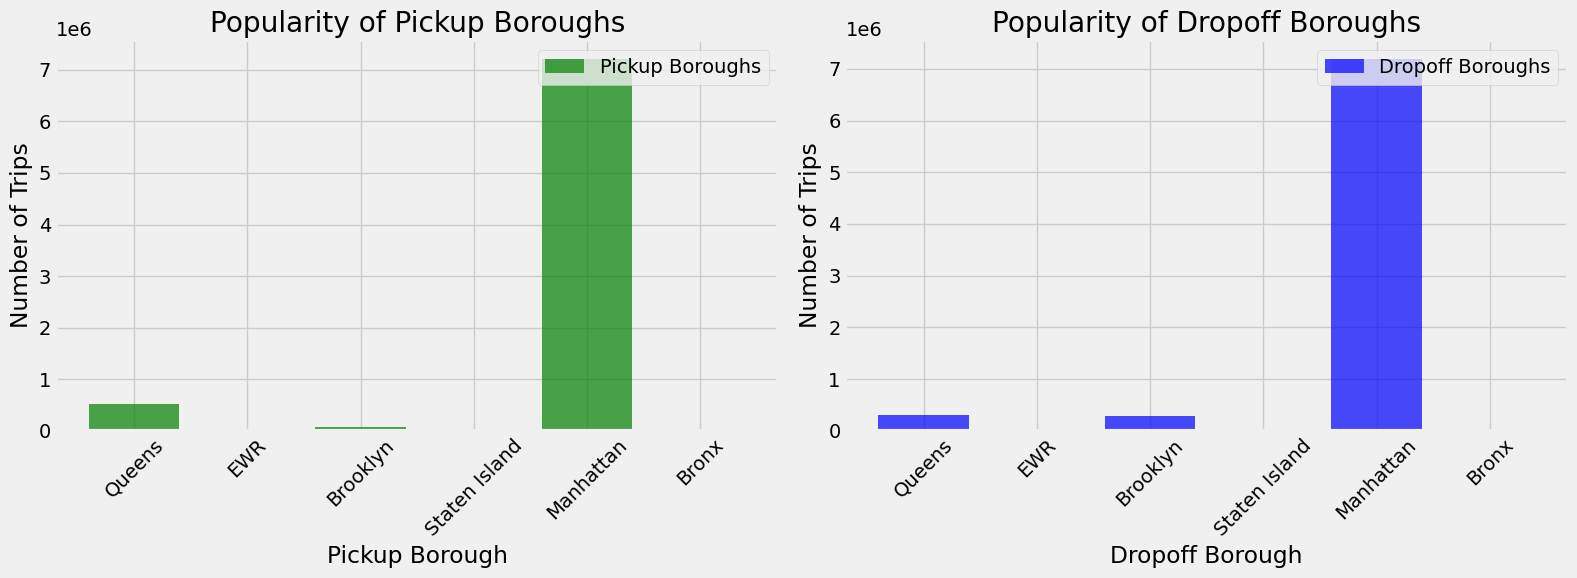

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].bar(pickup_borough_counts_pd['pu_borough'], pickup_borough_counts_pd['count'], color='green', alpha=0.7, label='Pickup Boroughs')
ax[0].set_xlabel('Pickup Borough')
ax[0].set_ylabel('Number of Trips')
ax[0].set_title('Popularity of Pickup Boroughs')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(loc='upper right')

ax[1].bar(dropoff_borough_counts_pd['do_borough'], dropoff_borough_counts_pd['count'], color='blue', alpha=0.7, label='Dropoff Boroughs')
ax[1].set_xlabel('Dropoff Borough')
ax[1].set_ylabel('Number of Trips')
ax[1].set_title('Popularity of Dropoff Boroughs')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Checking the Covariance between Features

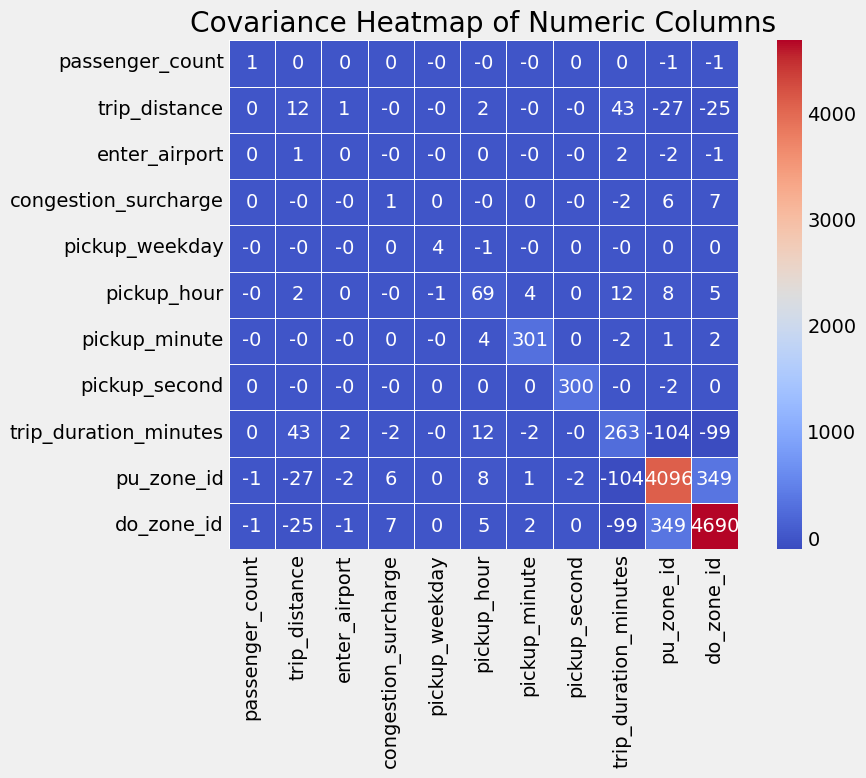

In [76]:
numeric_columns = [
    "passenger_count", "trip_distance", "enter_airport", "congestion_surcharge",
    "pickup_weekday", "pickup_hour", "pickup_minute", "pickup_second", 
    "trip_duration_minutes", "pu_zone_id", "do_zone_id"
]

numeric_df = df.select(numeric_columns).sample(fraction=0.1, seed=42).toPandas()

covariance_matrix = numeric_df.cov()

plt.figure(figsize=(10, 8))
sns.heatmap(
    covariance_matrix,
    annot=True, 
    cmap="coolwarm",
    fmt=".0f",  
    cbar=True,  
    square=True, 
    linewidths=0.5 
)
plt.title("Covariance Heatmap of Numeric Columns")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Adding Weather dataset


In [112]:
weather_data = pd.read_csv("../data/weather_data/merged_weather.csv")
weather_data.head(5)

,name,datetime,temp,humidity,precip,windgust,windspeed,winddir,cloudcover,visibility,severerisk,date,time,day,month,hour
0,"New York City,USA",2024-07-01 00:00:00,22.5,62.83,0.0,38.0,28.8,324,88.9,16.0,10,2024-07-01,00:00:00,1,7,0
1,"New York City,USA",2024-07-01 01:00:00,21.4,57.78,0.0,40.7,11.9,324,80.1,16.0,10,2024-07-01,01:00:00,1,7,1
2,"New York City,USA",2024-07-01 02:00:00,20.6,53.70,0.0,38.9,12.7,328,37.0,16.0,10,2024-07-01,02:00:00,1,7,2
3,"New York City,USA",2024-07-01 03:00:00,19.0,60.55,0.0,48.4,14.5,328,15.6,16.0,10,2024-07-01,03:00:00,1,7,3
4,"New York City,USA",2024-07-01 04:00:00,18.5,62.81,0.0,40.7,10.4,320,6.1,16.0,10,2024-07-01,04:00:00,1,7,4


In [78]:
weather_data.dtypes

name           object
datetime       object
temp          float64
humidity      float64
precip        float64
windgust      float64
windspeed     float64
winddir         int64
cloudcover    float64
visibility    float64
severerisk      int64
date           object
time           object
day             int64
month           int64
hour            int64
dtype: object

In [119]:
df

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, pu_zone_id: int, do_zone_id: int, congestion_surcharge: double, pu_borough: string, pu_zone: string, do_borough: string, do_zone: string, enter_airport: int, pickup_date: date, pickup_hour: int, pickup_minute: int, pickup_second: int, pickup_weekday: int, pickup_month: int, pickup_day: int, pickup_week_hour: int, dropoff_date: date, dropoff_hour: int, dropoff_minute: int, dropoff_second: int, dropoff_weekday: int, dropoff_month: int, dropoff_day: int, trip_duration_minutes: double]

In [202]:
weather_df = spark.createDataFrame(weather_data)

weather_df = weather_df.withColumn('date', to_date(col('date')))

# Perform the join with converted date columns
df = df.join(
    weather_df,
    (df['pickup_date'] == weather_df['date']) & 
    (df['pickup_hour'] == weather_df['hour']),
    "left"
)

In [205]:
columns_to_drop = [
    'name', 'day', 'time', 'RatecodeID', 'vendorid', 'store_and_fwd_flag', 'month', 'hour', 'date', 'datetime', 'severerisk']

df = df.drop(*columns_to_drop)

display(df)

DataFrame[tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: double, pu_zone_id: int, do_zone_id: int, congestion_surcharge: double, pu_borough: string, pu_zone: string, do_borough: string, do_zone: string, enter_airport: int, pickup_date: date, pickup_hour: int, pickup_minute: int, pickup_second: int, pickup_weekday: int, pickup_month: int, pickup_day: int, pickup_week_hour: int, dropoff_date: date, dropoff_hour: int, dropoff_minute: int, dropoff_second: int, dropoff_weekday: int, dropoff_month: int, dropoff_day: int, trip_duration_minutes: double, temp: double, humidity: double, precip: double, windgust: double, windspeed: double, winddir: bigint, cloudcover: double, visibility: double, temp: double, humidity: double, precip: double, windgust: double, windspeed: double, winddir: bigint, cloudcover: double, visibility: double]

In [181]:
scatter = df[['precip']].sample(fraction=0.1, seed=42).toPandas()

Py4JJavaError: An error occurred while calling o2161.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 11 in stage 417.0 failed 1 times, most recent failure: Lost task 11.0 in stage 417.0 (TID 2933) (An-Nguyen executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1170)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1089)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:500)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:159)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1126)
	... 36 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1170)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1089)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.IOException: CreateProcess error=2, The system cannot find the file specified
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:500)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:159)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1126)
	... 36 more


In [179]:
trip_duration_seconds_pd = df.select("trip_duration_seconds").sample(fraction=0.1, seed=42)

for i in scatter.columns:
    sns.scatterplot(x=scatter[i], y=trip_duration_seconds_pd['trip_duration_seconds'])
    plt.ylabel('Travel Duration (Seconds)')
    plt.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `trip_duration_seconds` cannot be resolved. Did you mean one of the following? [`trip_duration_minutes`, `dropoff_second`, `pickup_second`, `trip_distance`, `pu_zone_id`].;
'Project ['trip_duration_seconds]
+- Project [tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, dropoff_minute#19578, dropoff_second#19604, ... 12 more fields]
   +- Join LeftOuter, ((pickup_date#19281 = date#20362) AND (cast(pickup_hour#19297 as bigint) = hour#20345L))
      :- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 6 more fields]
      :  +- Filter ((speed_mph#19902 >= -1.756520399121623) AND (speed_mph#19902 <= 22.725199368185844))
      :     +- Filter ((speed_mph#19902 >= cast(0 as double)) AND (speed_mph#19902 <= cast(100 as double)))
      :        +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 7 more fields]
      :           +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 6 more fields]
      :              +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 7 more fields]
      :                 +- Filter (trip_duration_seconds#19790L <= cast(72000 as bigint))
      :                    +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 6 more fields]
      :                       +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 5 more fields]
      :                          +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 4 more fields]
      :                             +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 3 more fields]
      :                                +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, ... 2 more fields]
      :                                   +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, dropoff_hour#19553, minute(tpep_dropoff_datetime#19254, Some(Asia/Saigon)) AS dropoff_minute#19578]
      :                                      +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, dropoff_date#19529, hour(tpep_dropoff_datetime#19254, Some(Asia/Saigon)) AS dropoff_hour#19553]
      :                                         +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, pickup_week_hour#19414, to_date(tpep_dropoff_datetime#19254, None, Some(Asia/Saigon), false) AS dropoff_date#19529]
      :                                            +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, pickup_day#19392, ((pickup_weekday#19351 * 24) + pickup_hour#19297) AS pickup_week_hour#19414]
      :                                               +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, pickup_month#19371, day(cast(tpep_pickup_datetime#19239 as date)) AS pickup_day#19392]
      :                                                  +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, pickup_weekday#19351, month(cast(tpep_pickup_datetime#19239 as date)) AS pickup_month#19371]
      :                                                     +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, pickup_second#19332, (dayofweek(cast(tpep_pickup_datetime#19239 as date)) - 1) AS pickup_weekday#19351]
      :                                                        +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, pickup_minute#19314, second(tpep_pickup_datetime#19239, Some(Asia/Saigon)) AS pickup_second#19332]
      :                                                           +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, pickup_hour#19297, minute(tpep_pickup_datetime#19239, Some(Asia/Saigon)) AS pickup_minute#19314]
      :                                                              +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, pickup_date#19281, hour(tpep_pickup_datetime#19239, Some(Asia/Saigon)) AS pickup_hour#19297]
      :                                                                 +- Project [VendorID#16939, tpep_pickup_datetime#19239, tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202, to_date(tpep_pickup_datetime#19239, None, Some(Asia/Saigon), false) AS pickup_date#19281]
      :                                                                    +- Project [VendorID#16939, tpep_pickup_datetime#19239, to_timestamp(tpep_dropoff_datetime#16941, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Saigon), false) AS tpep_dropoff_datetime#19254, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202]
      :                                                                       +- Project [VendorID#16939, to_timestamp(tpep_pickup_datetime#16940, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Saigon), false) AS tpep_pickup_datetime#19239, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202]
      :                                                                          +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, enter_airport#19202]
      :                                                                             +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514, CASE WHEN (airport_fee#16957 > cast(0 as double)) THEN 1 ELSE 0 END AS enter_airport#19202]
      :                                                                                +- Filter NOT cast(passenger_count#16942L as bigint) IN (cast(7 as bigint),cast(8 as bigint),cast(9 as bigint),cast(0 as bigint))
      :                                                                                   +- Filter (((trip_distance#16943 >= -860.9822703212918) AND (trip_distance#16943 <= 871.3720275074589)) AND (trip_distance#16943 >= cast(1 as double)))
      :                                                                                      +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, pu_zone_id#17300, do_zone_id#17540, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514]
      :                                                                                         +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, pu_zone_id#17300, do_zone_id#17540, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276, do_borough#17488, do_zone#17514]
      :                                                                                            +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, pu_zone_id#17300, DOLocationID#16947 AS do_zone_id#17540, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276, zone_id#17433, do_borough#17488, do_zone#17514, zone_geom#17436]
      :                                                                                               +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, pu_zone_id#17300, DOLocationID#16947, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276, zone_id#17433, do_borough#17488, zone_name#17435 AS do_zone#17514, zone_geom#17436]
      :                                                                                                  +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, pu_zone_id#17300, DOLocationID#16947, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276, zone_id#17433, borough#17434 AS do_borough#17488, zone_name#17435, zone_geom#17436]
      :                                                                                                     +- Join Inner, (DOLocationID#16947 = zone_id#17433)
      :                                                                                                        :- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, pu_zone_id#17300, DOLocationID#16947, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, pu_borough#17252, pu_zone#17276]
      :                                                                                                        :  +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, PULocationID#16946 AS pu_zone_id#17300, DOLocationID#16947, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, zone_id#284, pu_borough#17252, pu_zone#17276, zone_geom#287]
      :                                                                                                        :     +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, PULocationID#16946, DOLocationID#16947, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, zone_id#284, pu_borough#17252, zone_name#286 AS pu_zone#17276, zone_geom#287]
      :                                                                                                        :        +- Project [VendorID#16939, tpep_pickup_datetime#16940, tpep_dropoff_datetime#16941, passenger_count#16942L, trip_distance#16943, RatecodeID#16944L, store_and_fwd_flag#16945, PULocationID#16946, DOLocationID#16947, payment_type#16948L, fare_amount#16949, extra#16950, mta_tax#16951, tip_amount#16952, tolls_amount#16953, improvement_surcharge#16954, total_amount#16955, congestion_surcharge#16956, Airport_fee#16957, zone_id#284, borough#285 AS pu_borough#17252, zone_name#286, zone_geom#287]
      :                                                                                                        :           +- Join Inner, (PULocationID#16946 = zone_id#284)
      :                                                                                                        :              :- Union false, false
      :                                                                                                        :              :  :- Relation [VendorID#16939,tpep_pickup_datetime#16940,tpep_dropoff_datetime#16941,passenger_count#16942L,trip_distance#16943,RatecodeID#16944L,store_and_fwd_flag#16945,PULocationID#16946,DOLocationID#16947,payment_type#16948L,fare_amount#16949,extra#16950,mta_tax#16951,tip_amount#16952,tolls_amount#16953,improvement_surcharge#16954,total_amount#16955,congestion_surcharge#16956,Airport_fee#16957] parquet
      :                                                                                                        :              :  :- Relation [VendorID#16977,tpep_pickup_datetime#16978,tpep_dropoff_datetime#16979,passenger_count#16980L,trip_distance#16981,RatecodeID#16982L,store_and_fwd_flag#16983,PULocationID#16984,DOLocationID#16985,payment_type#16986L,fare_amount#16987,extra#16988,mta_tax#16989,tip_amount#16990,tolls_amount#16991,improvement_surcharge#16992,total_amount#16993,congestion_surcharge#16994,Airport_fee#16995] parquet
      :                                                                                                        :              :  +- Relation [VendorID#17015,tpep_pickup_datetime#17016,tpep_dropoff_datetime#17017,passenger_count#17018L,trip_distance#17019,RatecodeID#17020L,store_and_fwd_flag#17021,PULocationID#17022,DOLocationID#17023,payment_type#17024L,fare_amount#17025,extra#17026,mta_tax#17027,tip_amount#17028,tolls_amount#17029,improvement_surcharge#17030,total_amount#17031,congestion_surcharge#17032,Airport_fee#17033] parquet
      :                                                                                                        :              +- Relation [zone_id#284,borough#285,zone_name#286,zone_geom#287] csv
      :                                                                                                        +- Relation [zone_id#17433,borough#17434,zone_name#17435,zone_geom#17436] csv
      +- Project [name#20330, datetime#20331, temp#20332, humidity#20333, precip#20334, windgust#20335, windspeed#20336, winddir#20337L, cloudcover#20338, visibility#20339, severerisk#20340L, to_date(date#20341, None, Some(Asia/Saigon), false) AS date#20362, time#20342, day#20343L, month#20344L, hour#20345L]
         +- LogicalRDD [name#20330, datetime#20331, temp#20332, humidity#20333, precip#20334, windgust#20335, windspeed#20336, winddir#20337L, cloudcover#20338, visibility#20339, severerisk#20340L, date#20341, time#20342, day#20343L, month#20344L, hour#20345L], false


base on the visualization we can drop column snow_fall and snow_depth because observing no noticeable trend or infomation

In [136]:
df = df.drop('snow_fall', 'snow_depth')

#### Relationship between Day Temperature and Number of Trips

In [ ]:
# import plotly.graph_objects as go

# grouped_data = (
#     df.groupBy("pickup_month", "pickup_day")
#     .agg(
#         F.avg("average_temperature").alias("avg_temperature"),
#         F.count("pickup_day").alias("trip_count")
#     )
#     .orderBy("pickup_month", "pickup_day")
#     .toPandas()
# )

# month_names = {7: "July", 8: "August", 9: "September"}
# for month in [7, 8, 9]:
#     month_data = grouped_data[grouped_data["pickup_month"] == month]
    
#     fig = go.Figure()

#     fig.add_trace(go.Scatter(
#         x=month_data['pickup_day'],
#         y=month_data['avg_temperature'],
#         mode='lines',
#         line=dict(color='orange', width=2),
#         name='Average Temperature'
#     ))

#     fig.add_trace(go.Scatter(
#         x=month_data['pickup_day'],
#         y=month_data['trip_count'],
#         mode='lines',
#         line=dict(color='blue', width=2),
#         name='Trip Count',
#         yaxis='y2'  # Use secondary y-axis
#     ))

#     fig.update_layout(
#         title=f"Trip Count and Average Temperature in {month_names[month]}",
#         xaxis=dict(title="Day of Month"),
#         yaxis=dict(title="Average Temperature (°C)", side="left"),
#         yaxis2=dict(title="Trip Count", overlaying='y', side="right"),
#         legend=dict(title="Legend"),
#         template="plotly_white"
#     )

#     fig.show()


#### Relationship between `prepcipitation` and `trip_count` vs `trip_duration`

In [ ]:
# import plotly.graph_objects as go

# precipitation_data = (
#     df.groupBy("precipitation")
#     .agg(
#         F.count("pickup_day").alias("trip_count"),
#         F.avg("trip_duration_seconds").alias("avg_trip_duration")
#     )
#     .orderBy("precipitation")
#     .toPandas()
# )

# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=precipitation_data['precipitation'],
#     y=precipitation_data['trip_count'],
#     mode='lines+markers',
#     line=dict(color='blue', width=2),
#     name='Trip Count'
# ))

# fig.add_trace(go.Scatter(
#     x=precipitation_data['precipitation'],
#     y=precipitation_data['avg_trip_duration'],
#     mode='lines+markers',
#     line=dict(color='orange', width=2, dash='dot'),
#     name='Avg Trip Duration',
#     yaxis='y2'  
# ))

# fig.update_layout(
#     title="Relationship Between Precipitation, Trip Count, and Avg Trip Duration",
#     xaxis=dict(title="Precipitation (mm)"),
#     yaxis=dict(title="Trip Count", side="left"),
#     yaxis2=dict(title="Avg Trip Duration (seconds)", overlaying='y', side="right"),
#     legend=dict(title="Legend"),
#     template="plotly_white"
# )

# fig.show()


* People avoid trips during rainy weather unless necessary, as reflected in the trip count. The sharp drop in trip count supports this behavioral trend.
* Longer average trip durations in rainy conditions indicate potential traffic congestion, slower driving speeds, or more cautious travel during rain.
* The slight increase in trip count for higher precipitation levels might indicate that some trips are unavoidable, regardless of weather conditions.

### Understanding the congestion trends in each Zone in NYC

In [188]:
df.select('congestion_surcharge').distinct().show()

+--------------------+
|congestion_surcharge|
+--------------------+
|                 0.0|
|                 2.5|
|                -2.5|
+--------------------+



In [201]:
borough_surcharge_spark = df.groupBy("pu_borough").agg(F.sum("congestion_surcharge").alias("Total_Surcharge"))

borough_surcharge_spark = borough_surcharge_spark.orderBy(F.desc("Total_Surcharge"))

# Sample a fraction of the data
small_df = borough_surcharge_spark.sample(fraction=0.01, seed=42)
borough_surcharge_pandas = small_df.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(borough_surcharge_pandas['pu_Borough'], borough_surcharge_pandas['Total_Surcharge'], color='skyblue')
plt.title('Total Congestion Surcharge by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Congestion Surcharge')
plt.xticks(rotation=45)
plt.show()



KeyboardInterrupt



##### Convert `congestion_surcharge` to `congestion_level` 

In [141]:
low_threshold = -2.5  
high_threshold = 2.5

df = df.withColumn(
    "congestion_level",
    F.when(df["congestion_surcharge"] <= low_threshold, "Low")
     .when((df["congestion_surcharge"] > low_threshold) & (df["congestion_surcharge"] < high_threshold), "Medium")
     .otherwise("High")
)

# df.select("congestion_surcharge", "congestion_level").show()


##### `PU_Zone` that has High `congestion_level`

In [143]:
high_congestion_zones = df.filter(F.col("congestion_level") == "High") \
    .groupBy("pu_zone", "pu_borough") \
    .count() \
    .orderBy(F.desc("count"))

# high_congestion_zones.show(10, truncate=False)

### Final Touch the Dataset

In [149]:
# Convert 'precipitation' to 'rain' (0 or 1)
df = df.withColumn("rain", F.when(df["precip"] > 0, 1).otherwise(0))

# Convert 'congestion_level' to 0, 1, or 2 (low, medium, high -> 0, 1, 2)
df = df.withColumn("congestion_level", 
                   F.when(df["congestion_level"] == "Low", 0)
                   .when(df["congestion_level"] == "Medium", 1)
                   .when(df["congestion_level"] == "High", 2)
                   .otherwise(-1))  # or set it to None if needed

# Show the updated dataframe with the transformed columns
# df.select("precip", "rain", "enter_airport", "congestion_level").show(truncate=False)

# Drop unnecessary columns
df = df.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime', 
             'pu_borough', 'pu_zone', 'do_borough', 'do_zone',
             'pickup_date', 'pickup_month', 'pickup_day', 'pickup_week_hour',
             'dropoff_date', 'dropoff_month', 'dropoff_day', 'cloudcover'
             'congestion_surcharge','precip')


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `precip` cannot be resolved. Did you mean one of the following? [`passenger_count`, `trip_distance`, `pu_zone_id`, `do_zone_id`, `pu_borough`, `pu_zone`, `do_borough`, `do_zone`, `enter_airport`, `pickup_date`, `pickup_hour`, `pickup_minute`, `pickup_second`, `pickup_weekday`, `pickup_month`, `pickup_day`, `pickup_week_hour`, `dropoff_date`, `dropoff_hour`, `dropoff_minute`, `dropoff_second`, `dropoff_weekday`, `dropoff_month`, `dropoff_day`, `trip_duration_minutes`, `temp`, `humidity`, `windgust`, `windspeed`, `winddir`, `cloudcover`, `visibility`, `congestion_level`, `rain`].

In [148]:
df

DataFrame[passenger_count: bigint, trip_distance: double, pu_zone_id: int, do_zone_id: int, pu_borough: string, pu_zone: string, do_borough: string, do_zone: string, enter_airport: int, pickup_date: date, pickup_hour: int, pickup_minute: int, pickup_second: int, pickup_weekday: int, pickup_month: int, pickup_day: int, pickup_week_hour: int, dropoff_date: date, dropoff_hour: int, dropoff_minute: int, dropoff_second: int, dropoff_weekday: int, dropoff_month: int, dropoff_day: int, trip_duration_minutes: double, temp: double, humidity: double, windgust: double, windspeed: double, winddir: bigint, cloudcover: double, visibility: double, congestion_level: int, rain: int]

In [62]:


def missing_ratio_spark(df):
    total_rows = df.count()

    missing_counts = []
    for column in df.columns:
        if dict(df.dtypes)[column] in ['float', 'double']:
            missing_count = df.filter(F.col(column).isNull() | F.isnan(column)).count()
        else:
            missing_count = df.filter(F.col(column).isNull()).count()
        
        missing_ratio = (missing_count / total_rows) * 100
        missing_counts.append((column, missing_ratio))
    
    missing_data_df = spark.createDataFrame(missing_counts, ["column_name", "missing_ratio"])

    missing_data_df = missing_data_df.orderBy(F.col("missing_ratio"), ascending=False)

    #missing_data_df = missing_data_df.filter(F.col("missing_ratio") > 0)
    
    return missing_data_df

missing_data = missing_ratio_spark(df)
missing_data.show()


+--------------------+------------------+
|         column_name|     missing_ratio|
+--------------------+------------------+
|          visibility|0.4578411367600857|
|                temp|0.4578411367600857|
|              precip|0.4578411367600857|
|            humidity|0.4578411367600857|
|          severerisk|0.4578411367600857|
|            windgust|0.4578411367600857|
|                 day|0.4578411367600857|
|           windspeed|0.4578411367600857|
|             winddir|0.4578411367600857|
|          cloudcover|0.4578411367600857|
|             PU_Zone|               0.0|
|        dropoff_time|               0.0|
|          DO_Borough|               0.0|
|         pickup_hour|               0.0|
|             DO_Zone|               0.0|
|           speed_mph|               0.0|
|       enter_airport|               0.0|
|          pickup_day|               0.0|
|         pickup_date|               0.0|
|trip_duration_min...|               0.0|
+--------------------+------------

# Feature selection

### Calculate correlation matrix

In [63]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Select numeric columns from the original DataFrame
numeric_columns = [
    "passenger_count", "trip_distance", "congestion_level", "PULocationID", "DOLocationID",
    "pickup_hour", "pickup_minute", "dropoff_minute", "trip_duration_minutes",
    "speed_mph", "visibility", "windspeed", "winddir",
    "temp", "precip", "humidity", "severerisk", "windgust", "day", "cloudcover", "rain"
]

# Sample the DataFrame to reduce size (10% sample in this case)
sampled_df = df.select(numeric_columns).sample(fraction=0.1, seed=42)

# Assemble the numeric columns into a single vector column
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(sampled_df)

# Calculate the Pearson correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features", method="pearson")



24/12/09 11:12:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/09 11:12:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


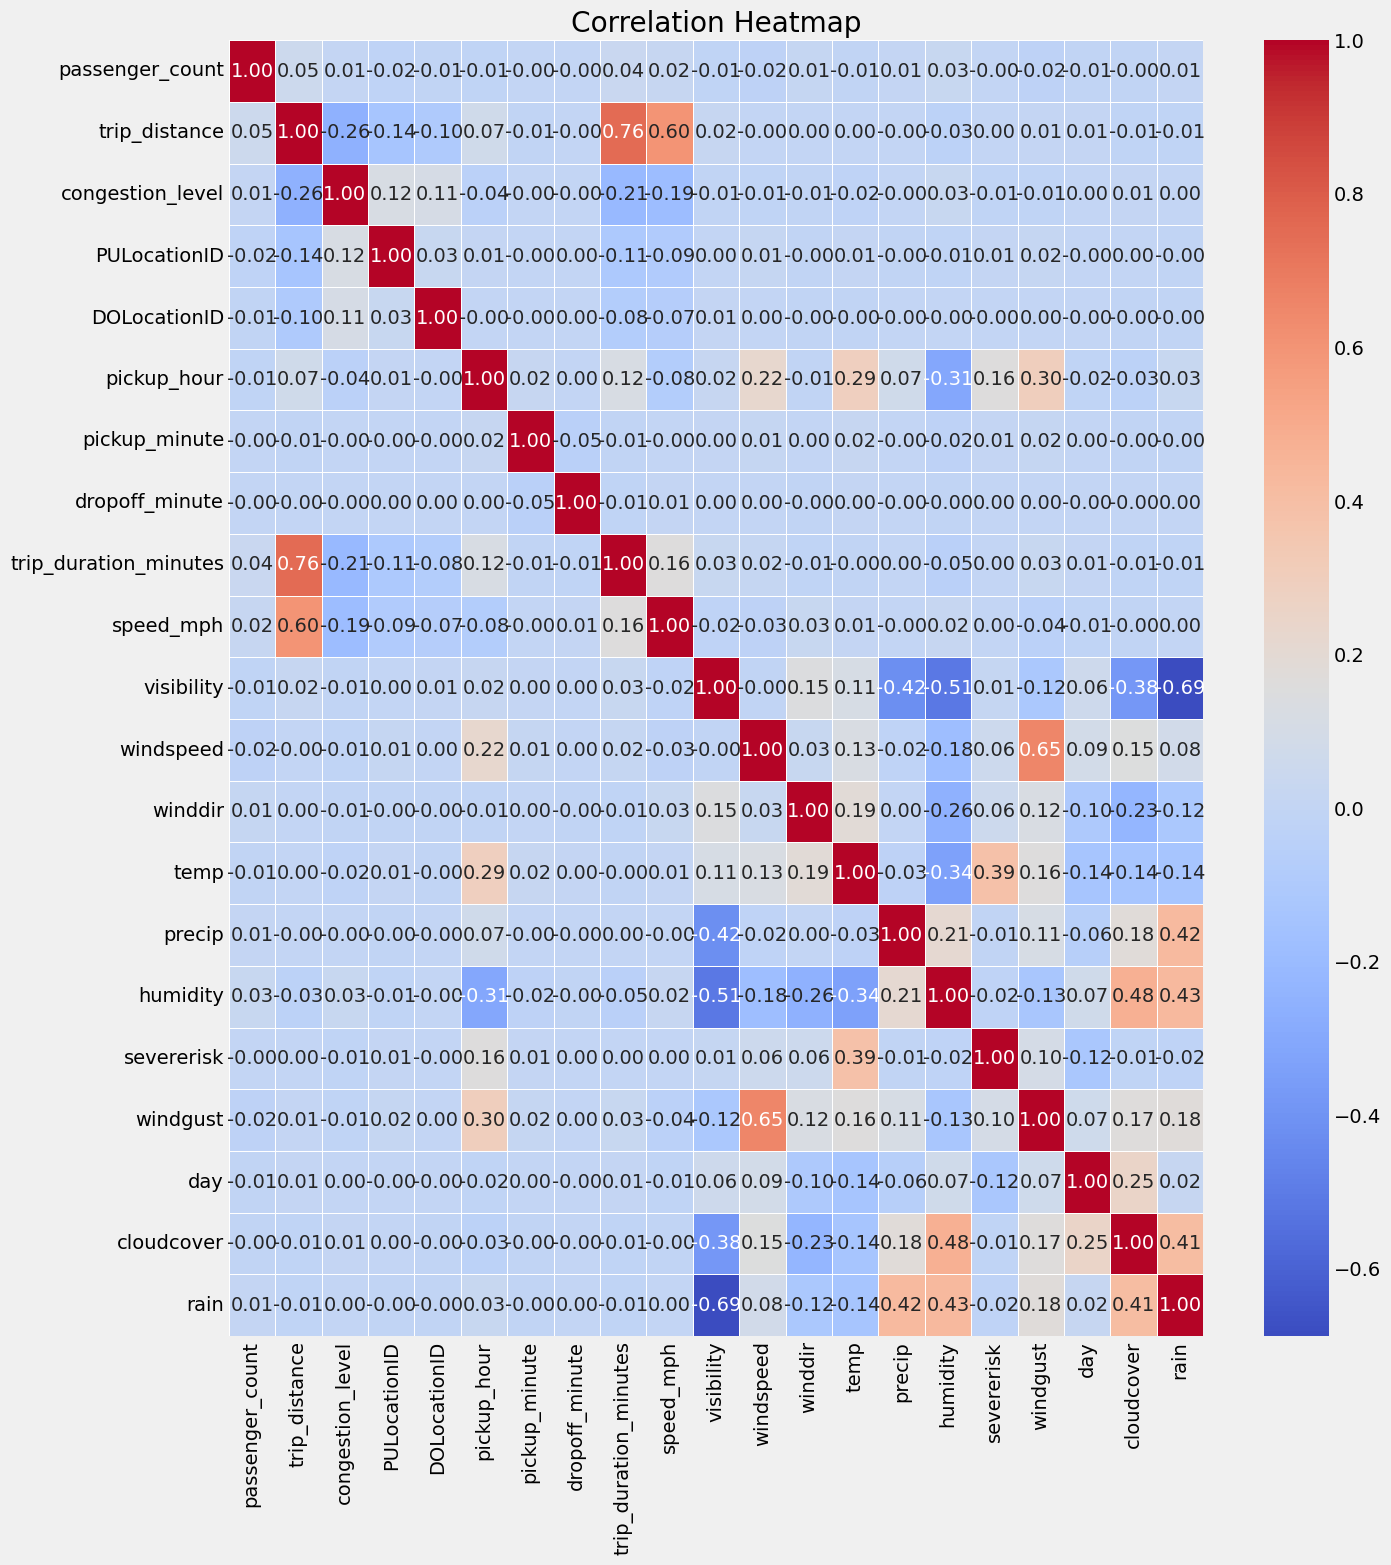

In [64]:
# Convert the correlation matrix to a Pandas DataFrame (optional)
corr_matrix_spark = correlation_matrix.head()[0]  # Extract the matrix
corr_matrix_pd = pd.DataFrame(corr_matrix_spark.toArray(), columns=numeric_columns, index=numeric_columns)


plt.figure(figsize=(14, 16))  # Set the figure size
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title for the heatmap
plt.title("Correlation Heatmap")
plt.show()


### Slipt data divide 2 part: high_corr and low_corr

In [65]:
correlation_with_target = corr_matrix_pd["trip_duration_minutes"]

# Set threshold for high and low correlation
threshold = 0.1

# Split features into high and low correlation groups
high_corr_features = correlation_with_target[correlation_with_target.abs() >= threshold].index.tolist()
low_corr_features = correlation_with_target[correlation_with_target.abs() < threshold].index.tolist()

print("High Correlation Features:", high_corr_features)
print("Low Correlation Features:", low_corr_features)


High Correlation Features: ['trip_distance', 'congestion_level', 'PULocationID', 'pickup_hour', 'trip_duration_minutes', 'speed_mph']
Low Correlation Features: ['passenger_count', 'DOLocationID', 'pickup_minute', 'dropoff_minute', 'visibility', 'windspeed', 'winddir', 'temp', 'precip', 'humidity', 'severerisk', 'windgust', 'day', 'cloudcover', 'rain']


In [66]:
# Subset with high correlation features
subset_high_corr = df.select(high_corr_features).sample(fraction=0.1, seed=42)

# Subset with low correlation features
subset_low_corr = df.select(low_corr_features).sample(fraction=0.1, seed=42)
print("Subset with High Correlation Features:")
subset_high_corr.show(5)

print("Subset with Low Correlation Features:")
subset_low_corr.show(5)


Subset with High Correlation Features:
+-------------+----------------+------------+-----------+---------------------+------------------+
|trip_distance|congestion_level|PULocationID|pickup_hour|trip_duration_minutes|         speed_mph|
+-------------+----------------+------------+-----------+---------------------+------------------+
|         3.34|               2|         230|          7|   14.266666666666667|14.046728971962615|
|          2.9|               2|         100|          7|   17.083333333333332|10.185365853658537|
|         1.33|               2|         229|          7|    9.383333333333333| 8.504440497335702|
|         3.91|               2|         186|          7|                20.45|11.471882640586799|
|         1.79|               2|         249|          7|                 12.0|              8.95|
+-------------+----------------+------------+-----------+---------------------+------------------+
only showing top 5 rows

Subset with Low Correlation Features:


+---------------+------------+-------------+--------------+----------+---------+-------+----+------+--------+----------+--------+---+----------+----+
|passenger_count|DOLocationID|pickup_minute|dropoff_minute|visibility|windspeed|winddir|temp|precip|humidity|severerisk|windgust|day|cloudcover|rain|
+---------------+------------+-------------+--------------+----------+---------+-------+----+------+--------+----------+--------+---+----------+----+
|              1|          83|           48|             6|      16.0|     24.3|      1|26.7|   0.0|   43.34|        10|    47.8|  1|      19.2|   0|
|              1|         163|           49|            54|      16.0|     24.3|      1|26.7|   0.0|   43.34|        10|    47.8|  1|      19.2|   0|
|              1|         229|           56|             1|      16.0|     24.3|      1|26.7|   0.0|   43.34|        10|    47.8|  1|      19.2|   0|
|              1|         234|           57|             5|      16.0|     24.3|      1|26.7|   0.0|

### Calculate VIF 

In [67]:
from pyspark.ml.regression import LinearRegression

# Function to calculate VIF
def calculate_vif(df, features):
    vif_values = []
    for feature in features:
        # Exclude the current feature from predictors
        predictors = [col for col in features if col != feature]
        assembler = VectorAssembler(inputCols=predictors, outputCol="features", handleInvalid="skip")
        assembled_df = assembler.transform(df.select(predictors + [feature]))
        
        # Fit a linear regression model
        lr = LinearRegression(featuresCol="features", labelCol=feature)
        lr_model = lr.fit(assembled_df)
        
        # Calculate R-squared and VIF
        r2 = lr_model.summary.r2
        vif = 1 / (1 - r2) if r2 < 1 else float("inf")  # Avoid division by zero
        vif_values.append((feature, vif))
    
    return pd.DataFrame(vif_values, columns=["Feature", "VIF"])

# Calculate VIF for high correlation subset
high_corr_features = [f for f in high_corr_features if f != "trip_duration_minutes"]  # Exclude target
vif_high_corr = calculate_vif(subset_high_corr, high_corr_features)

print("VIF for High Correlation Subset:")
print(vif_high_corr)

# Calculate VIF for low correlation subset
low_corr_features = [f for f in low_corr_features if f != "trip_duration_minutes"]  # Exclude target
vif_low_corr = calculate_vif(subset_low_corr, low_corr_features)

print("VIF for Low Correlation Subset:")
print(vif_low_corr)


24/12/09 11:12:24 WARN Instrumentation: [ce0d89b9] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/12/09 11:12:32 WARN Instrumentation: [3a01797b] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:40 WARN Instrumentation: [c14ea39c] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:47 WARN Instrumentation: [4d1f729e] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:54 WARN Instrumentation: [e46c17e9] regParam is zero, which might cause numerical instability and overfitting.


VIF for High Correlation Subset:
            Feature       VIF
0     trip_distance  1.669879
1  congestion_level  1.081675
2      PULocationID  1.027048
3       pickup_hour  1.030190
4         speed_mph  1.612686


24/12/09 11:13:03 WARN Instrumentation: [2ed54b7e] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:08 WARN Instrumentation: [78e96887] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:16 WARN Instrumentation: [f54e3535] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:23 WARN Instrumentation: [985541bc] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:32 WARN Instrumentation: [8310c998] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:40 WARN Instrumentation: [f26418b8] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:47 WARN Instrumentation: [d83ed59e] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:56 WARN Instrumentation: [6f94fcd1] regParam is zero, which might cause numerical instability and overf

VIF for Low Correlation Subset:
            Feature       VIF
0   passenger_count  1.001901
1      DOLocationID  1.000133
2     pickup_minute  1.003272
3    dropoff_minute  1.002104
4        visibility  2.304017
5         windspeed  1.849198
6           winddir  1.134168
7              temp  1.385423
8            precip  1.287839
9          humidity  1.925789
10       severerisk  1.211810
11         windgust  1.922949
12              day  1.135265
13       cloudcover  1.595554
14             rain  2.114870


### Drop column with low VIF

In [68]:
df = df.drop('passenger_count','pickup_minute','dropoff_minute','windspeed','winddir','temp','precip',' severerisk',' day','cloudcover' )

### Calculate correlation matrix after drop

In [70]:
# Select numeric columns from the original DataFrame
numeric_columns_1 = [
     "trip_distance", "congestion_level", "PULocationID", "DOLocationID", 
     "trip_duration_minutes","speed_mph", "visibility", "humidity", "windgust","rain","pickup_hour"
]

# Sample the DataFrame to reduce size (10% sample in this case)
sampled_df_1= df.select(numeric_columns_1).sample(fraction=0.1, seed=42)

# Assemble the numeric columns into a single vector column
assembler_1= VectorAssembler(inputCols=numeric_columns_1, outputCol="features", handleInvalid="skip")
assembled_df_1 = assembler_1.transform(sampled_df_1)

# Calculate the Pearson correlation matrix
correlation_matrix_1 = Correlation.corr(assembled_df_1, "features", method="pearson")



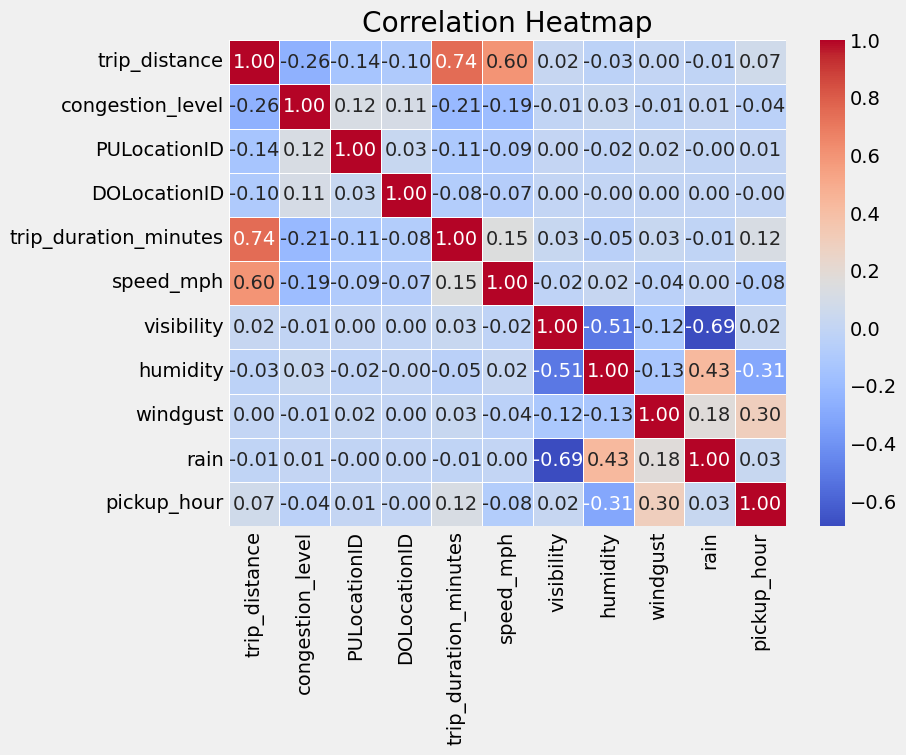

In [72]:
# Convert the correlation matrix to a Pandas DataFrame (optional)
corr_matrix_spark_1 = correlation_matrix_1.head()[0]  # Extract the matrix
corr_matrix_pd_1= pd.DataFrame(corr_matrix_spark_1.toArray(), columns=numeric_columns_1, index=numeric_columns_1)


plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(corr_matrix_pd_1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title for the heatmap
plt.title("Correlation Heatmap")
plt.show()


In [88]:
df = df.drop("PU_Borough","DO_Borough","pickup_date","day","enter_airport","pickup_date","dropoff_date","pickup_time","dropoff_time","dropoff_weekday","pickup_weekday","pickup_second","dropoff_second",
             "pickup_month","dropoff_month","pickup_day","dropoff_day","PU_Zone","DO_Zone","pickup_week_hour","dropoff_hour","severerisk")

In [95]:
df.coalesce(1).write.csv("../data/dataset.csv", header=True, mode = "overwrite")